# I. Importing data and required libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-airline-sentiment/database.sqlite
/kaggle/input/twitter-airline-sentiment/Tweets.csv


In [2]:
pip install demoji

Note: you may need to restart the kernel to use updated packages.


In [30]:
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.utils as ku
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import re
import demoji
import emoji
demoji.download_codes()

... OK (Got response in 0.12 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [4]:
data = pd.read_csv('/kaggle/input/twitter-airline-sentiment/Tweets.csv')
data

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


# II. Some EDA(not really)

In [5]:
virgin_neg, virgin_eq, virgin_pos = (data['airline_sentiment'].loc[data['airline']=='Virgin America'].value_counts())
united_neg, united_eq, united_pos = (data['airline_sentiment'].loc[data['airline']=='United'].value_counts())
southwest_neg, southwest_eq, southwest_pos = (data['airline_sentiment'].loc[data['airline']=='Southwest'].value_counts())
delta_neg, delta_eq, delta_pos = (data['airline_sentiment'].loc[data['airline']=='Delta'].value_counts())
USairways_neg, USairways_eq, USairways_pos = (data['airline_sentiment'].loc[data['airline']=='US Airways'].value_counts())
american_neg, american_eq, american_pos = (data['airline_sentiment'].loc[data['airline']=='American'].value_counts())

print('Sentiment type by airline:\n')
print('Virgin America: positive =',virgin_pos, 'negative =',virgin_neg, 'neutral =', virgin_eq)
print('United: positive =',united_pos, 'negative =',united_neg, 'neutral =', united_eq)  
print('Southwest: positive =',southwest_pos, 'negative =',southwest_neg, 'neutral =', southwest_eq)
print('Delta: positive =',delta_pos, 'negative =',delta_neg, 'neutral =', delta_eq)
print('US Airways: positive =',USairways_pos, 'negative =',USairways_neg, 'neutral =', USairways_eq)
print('American: positive =',american_pos, 'negative =',american_neg, 'neutral =', american_eq)

Sentiment type by airline:

Virgin America: positive = 152 negative = 181 neutral = 171
United: positive = 492 negative = 2633 neutral = 697
Southwest: positive = 570 negative = 1186 neutral = 664
Delta: positive = 544 negative = 955 neutral = 723
US Airways: positive = 269 negative = 2263 neutral = 381
American: positive = 336 negative = 1960 neutral = 463


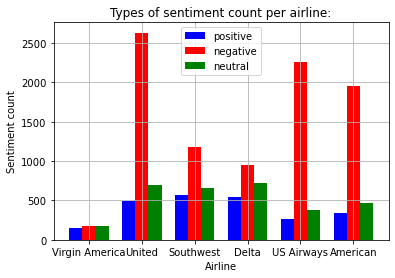

In [6]:
plt.xlabel('Airline')
plt.ylabel('Sentiment count')
X = ['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways', 'American']
positive = [virgin_pos, united_pos, southwest_pos, delta_pos, USairways_pos, american_pos]
negative = [virgin_neg, united_neg, southwest_neg, delta_neg, USairways_neg, american_neg]
neutral = [virgin_eq, united_eq, southwest_eq, delta_eq, USairways_eq, american_eq]
br1 = np.arange(6) 
br2 = [x + 0.25 for x in br1] 
br3 = [x + 0.25 for x in br2]

plt.bar(br1, positive, color='b', label='positive', width=0.25)
plt.bar(br2, negative, color='r', label='negative', width=0.25)
plt.bar(br3, neutral, color='g', label='neutral', width=0.25)
plt.xticks([r+0.25 for r in range(6)], X)
plt.title('Types of sentiment count per airline:')
plt.legend()
plt.grid()
plt.show()



# III. Text Preprocessing

In [7]:
StopWords = set(stopwords.words('english'))

def text_preprocess(text):
    text = ' '.join([word.lower() for word in text.split() if word.lower() not in StopWords])
    text = ' '.join([word for word in text.split() if ('@' not in word and 'http' not in word and 'https' not in word and '#' not in word)])
    trans = str.maketrans('','',string.punctuation)
    text = text.translate(trans)
    return text

data['text'] = data['text'].apply(text_preprocess)
data.head()        
    

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,said,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,plus added commercials experience tacky,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,today must mean need take another trip,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,really aggressive blast obnoxious entertainmen...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,really big bad thing,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# IV. Tokenization and Lemmatization

In [8]:
X = data['text']
X = X.tolist()
def lemmatize(data):
    lemmatizer = WordNetLemmatizer()
    lem_data = []
    for text in data:
        lem_text = ''
        for word in text.split():
            word = lemmatizer.lemmatize(word)
            word = lemmatizer.lemmatize(word, pos='v')
            lem_text = lem_text + ' ' + word
        lem_data.append(lem_text)
    return lem_data
        
X_lem = lemmatize(X)
print(X_lem)

[' say', ' plus add commercial experience tacky', ' today must mean need take another trip', ' really aggressive blast obnoxious entertainment guest face amp little recourse', ' really big bad thing', ' seriously would pay 30 flight seat play really bad thing fly va', ' yes nearly every time fly vx “ear worm” won’t go away', ' really miss prime opportunity men without hat parody there', ' well didnt…but do d', ' amaze arrive hour early good me', ' know suicide second lead cause death among teen 1024', ' lt3 pretty graphic much better minimal iconography d', ' great deal already think 2nd trip amp even go 1st trip yet p', ' im fly sky again u take away travel', ' thank', ' sfopdx schedule still mia', ' excite first cross country flight lax mco ive hear nothing great thing virgin america', ' fly nyc sfo last week fully sit seat due two large gentleman either side me help', ' ❤️ fly ☺️👍', ' know would amazingly awesome bosfll please want fly you', ' first fare may three time carrier seat 

In [9]:
#Handling emojis in data, replacing them with them corresponding text words.
emoji2text = {}
for text in X_lem:
    emoji2text.update(demoji.findall(text))
    
emoji2text

{'👍': 'thumbs up',
 '☺️': 'smiling face',
 '❤️': 'red heart',
 '😡': 'pouting face',
 '😢': 'crying face',
 '💜': 'purple heart',
 '✈': 'airplane',
 '🍷': 'wine glass',
 '✈️': 'airplane',
 '💺': 'seat',
 '😊': 'smiling face with smiling eyes',
 '👌': 'OK hand',
 '😍': 'smiling face with heart-eyes',
 '💕': 'two hearts',
 '🌞': 'sun with face',
 '😃': 'grinning face with big eyes',
 '😩': 'weary face',
 '😭': 'loudly crying face',
 '😎': 'smiling face with sunglasses',
 '🙉': 'hear-no-evil monkey',
 '😁': 'beaming face with smiling eyes',
 '❄️': 'snowflake',
 '👏': 'clapping hands',
 '💗': 'growing heart',
 '😒': 'unamused face',
 '👎': 'thumbs down',
 '😄': 'grinning face with smiling eyes',
 '😀': 'grinning face',
 '😘': 'face blowing a kiss',
 '👸': 'princess',
 '🇺🇸': 'flag: United States',
 '🎀': 'ribbon',
 '🇬🇧': 'flag: United Kingdom',
 '🌏': 'globe showing Asia-Australia',
 '😥': 'sad but relieved face',
 '😉': 'winking face',
 '😱': 'face screaming in fear',
 '✨': 'sparkles',
 '🎉': 'party popper',
 '💤': 'zzz

In [14]:
X_lem_demoji = []
for text in X_lem:
    for emoji, txt in emoji2text.items():
        if emoji in text:
            text = re.sub(emoji, txt+' ', text)
    X_lem_demoji.append(text)
X_lem_demoji

[' say',
 ' plus add commercial experience tacky',
 ' today must mean need take another trip',
 ' really aggressive blast obnoxious entertainment guest face amp little recourse',
 ' really big bad thing',
 ' seriously would pay 30 flight seat play really bad thing fly va',
 ' yes nearly every time fly vx “ear worm” won’t go away',
 ' really miss prime opportunity men without hat parody there',
 ' well didnt…but do d',
 ' amaze arrive hour early good me',
 ' know suicide second lead cause death among teen 1024',
 ' lt3 pretty graphic much better minimal iconography d',
 ' great deal already think 2nd trip amp even go 1st trip yet p',
 ' im fly sky again u take away travel',
 ' thank',
 ' sfopdx schedule still mia',
 ' excite first cross country flight lax mco ive hear nothing great thing virgin america',
 ' fly nyc sfo last week fully sit seat due two large gentleman either side me help',
 ' red heart  fly smiling face thumbs up ',
 ' know would amazingly awesome bosfll please want fly 

In [50]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['airline_sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X_lem_demoji, y, random_state=0)
y_train_true = y_train
y_train = ku.to_categorical(y_train, num_classes=3)
y_test_true = y_test
y_test = ku.to_categorical(y_test, num_classes=3)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index)
max_len = 100
train_seq = tokenizer.texts_to_sequences(X_train)
train_pad = pad_sequences(train_seq, maxlen=max_len)
test_seq = tokenizer.texts_to_sequences(X_test)
test_pad = pad_sequences(test_seq, maxlen=max_len)

# V. Training model

In [22]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size+1, 300, input_length=max_len),
    keras.layers.SpatialDropout1D(0.5),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    keras.layers.Bidirectional(keras.layers.LSTM(32, dropout=0.3, recurrent_dropout=0.3)),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_pad, y_train, epochs=20, batch_size=512, validation_data=(test_pad, y_test))

Epoch 1/20
22/22 [==============================] - ETA: 0s - loss: 1.0918 - accuracy: 0.37 - ETA: 16s - loss: 0.9949 - accuracy: 0.511 - ETA: 20s - loss: 1.0292 - accuracy: 0.459 - ETA: 21s - loss: 1.0073 - accuracy: 0.499 - ETA: 22s - loss: 0.9948 - accuracy: 0.519 - ETA: 22s - loss: 0.9761 - accuracy: 0.538 - ETA: 22s - loss: 0.9506 - accuracy: 0.550 - ETA: 20s - loss: 0.9388 - accuracy: 0.559 - ETA: 19s - loss: 0.9209 - accuracy: 0.568 - ETA: 18s - loss: 0.9085 - accuracy: 0.577 - ETA: 16s - loss: 0.8912 - accuracy: 0.585 - ETA: 15s - loss: 0.8809 - accuracy: 0.592 - ETA: 14s - loss: 0.8641 - accuracy: 0.600 - ETA: 12s - loss: 0.8495 - accuracy: 0.609 - ETA: 11s - loss: 0.8419 - accuracy: 0.616 - ETA: 9s - loss: 0.8315 - accuracy: 0.623 - ETA: 7s - loss: 0.8226 - accuracy: 0.62 - ETA: 6s - loss: 0.8172 - accuracy: 0.63 - ETA: 4s - loss: 0.8100 - accuracy: 0.63 - ETA: 3s - loss: 0.8017 - accuracy: 0.64 - ETA: 1s - loss: 0.7929 - accuracy: 0.65 - ETA: 0s - loss: 0.7906 - accuracy: 0.

22/22 [==============================] - ETA: 0s - loss: 0.1007 - accuracy: 0.96 - ETA: 17s - loss: 0.1036 - accuracy: 0.961 - ETA: 22s - loss: 0.0996 - accuracy: 0.965 - ETA: 23s - loss: 0.0993 - accuracy: 0.966 - ETA: 23s - loss: 0.1008 - accuracy: 0.965 - ETA: 23s - loss: 0.0994 - accuracy: 0.965 - ETA: 22s - loss: 0.0978 - accuracy: 0.966 - ETA: 21s - loss: 0.0981 - accuracy: 0.966 - ETA: 19s - loss: 0.1009 - accuracy: 0.964 - ETA: 18s - loss: 0.1011 - accuracy: 0.964 - ETA: 16s - loss: 0.1027 - accuracy: 0.964 - ETA: 15s - loss: 0.1042 - accuracy: 0.964 - ETA: 14s - loss: 0.1043 - accuracy: 0.963 - ETA: 12s - loss: 0.1065 - accuracy: 0.963 - ETA: 11s - loss: 0.1053 - accuracy: 0.963 - ETA: 9s - loss: 0.1041 - accuracy: 0.964 - ETA: 7s - loss: 0.1050 - accuracy: 0.96 - ETA: 6s - loss: 0.1047 - accuracy: 0.96 - ETA: 4s - loss: 0.1042 - accuracy: 0.96 - ETA: 3s - loss: 0.1034 - accuracy: 0.96 - ETA: 1s - loss: 0.1037 - accuracy: 0.96 - ETA: 0s - loss: 0.1036 - accuracy: 0.96 - 36s 2s

22/22 [==============================] - ETA: 0s - loss: 0.0558 - accuracy: 0.98 - ETA: 17s - loss: 0.0573 - accuracy: 0.980 - ETA: 21s - loss: 0.0537 - accuracy: 0.981 - ETA: 22s - loss: 0.0548 - accuracy: 0.982 - ETA: 22s - loss: 0.0586 - accuracy: 0.980 - ETA: 22s - loss: 0.0557 - accuracy: 0.981 - ETA: 22s - loss: 0.0569 - accuracy: 0.981 - ETA: 21s - loss: 0.0565 - accuracy: 0.981 - ETA: 20s - loss: 0.0578 - accuracy: 0.980 - ETA: 18s - loss: 0.0556 - accuracy: 0.981 - ETA: 17s - loss: 0.0554 - accuracy: 0.981 - ETA: 15s - loss: 0.0558 - accuracy: 0.980 - ETA: 14s - loss: 0.0571 - accuracy: 0.979 - ETA: 13s - loss: 0.0605 - accuracy: 0.979 - ETA: 11s - loss: 0.0607 - accuracy: 0.978 - ETA: 10s - loss: 0.0596 - accuracy: 0.978 - ETA: 8s - loss: 0.0591 - accuracy: 0.979 - ETA: 6s - loss: 0.0607 - accuracy: 0.97 - ETA: 5s - loss: 0.0622 - accuracy: 0.97 - ETA: 3s - loss: 0.0624 - accuracy: 0.97 - ETA: 1s - loss: 0.0629 - accuracy: 0.97 - ETA: 0s - loss: 0.0632 - accuracy: 0.97 - 39s 

In [23]:
y_pred = model.predict_classes(test_pad)
y_pred

array([0, 0, 0, ..., 0, 2, 1])

In [28]:
#accuracy with Bi-LSTM neural network
print(accuracy_score(y_test_true, y_pred))

0.7289617486338797


In [52]:
#Tfidf Vectorization, predictions using Logistic Regression.
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.9)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

clf = LogisticRegression(max_iter=1000).fit(X_train_tfidf, y_train_true)
y_pred = clf.predict(X_test_tfidf)
print('Accuracy with Logistic Regression and tfidf Vectorization',accuracy_score(y_test_true, y_pred))

Accuracy with Logistic Regression and tfidf Vectorization 0.7800546448087432
